
Model Parameters:
D =  0.600, E =  0.200
Alpha =  0.200, Beta =  1.000, Gamma =  1.000

FVM Parameters:
Cells = 26  dx = 0.0385
DRUG RELEASE TRACKING MODEL - ENHANCED FVM VERSION
Three-PDE System with Finite Volume Method

Solving ODE system...
Spatial points: 26
Time points: 6
Total equations: 78
Integration from t = 0 to t = 2
Solution completed.
Function calls: 966

NUMERICAL RESULTS (FVM)


Time t = 0.0
       x       u(x,t)       v(x,t)       s(x,t)
--------------------------------------------------
  -0.481    0.750000    0.250000    0.000000
  -0.288    0.750000    0.250000    0.000000
  -0.096    0.750000    0.250000    0.000000
   0.096    0.750000    0.250000    0.000000
   0.288    0.750000    0.250000    0.000000
   0.481    0.750000    0.250000    0.000000


Time t = 2.0
       x       u(x,t)       v(x,t)       s(x,t)
--------------------------------------------------
  -0.481    0.056029    0.157048   -0.131032
  -0.288    0.071446    0.176133   -0.135421
  -0.096    0.0

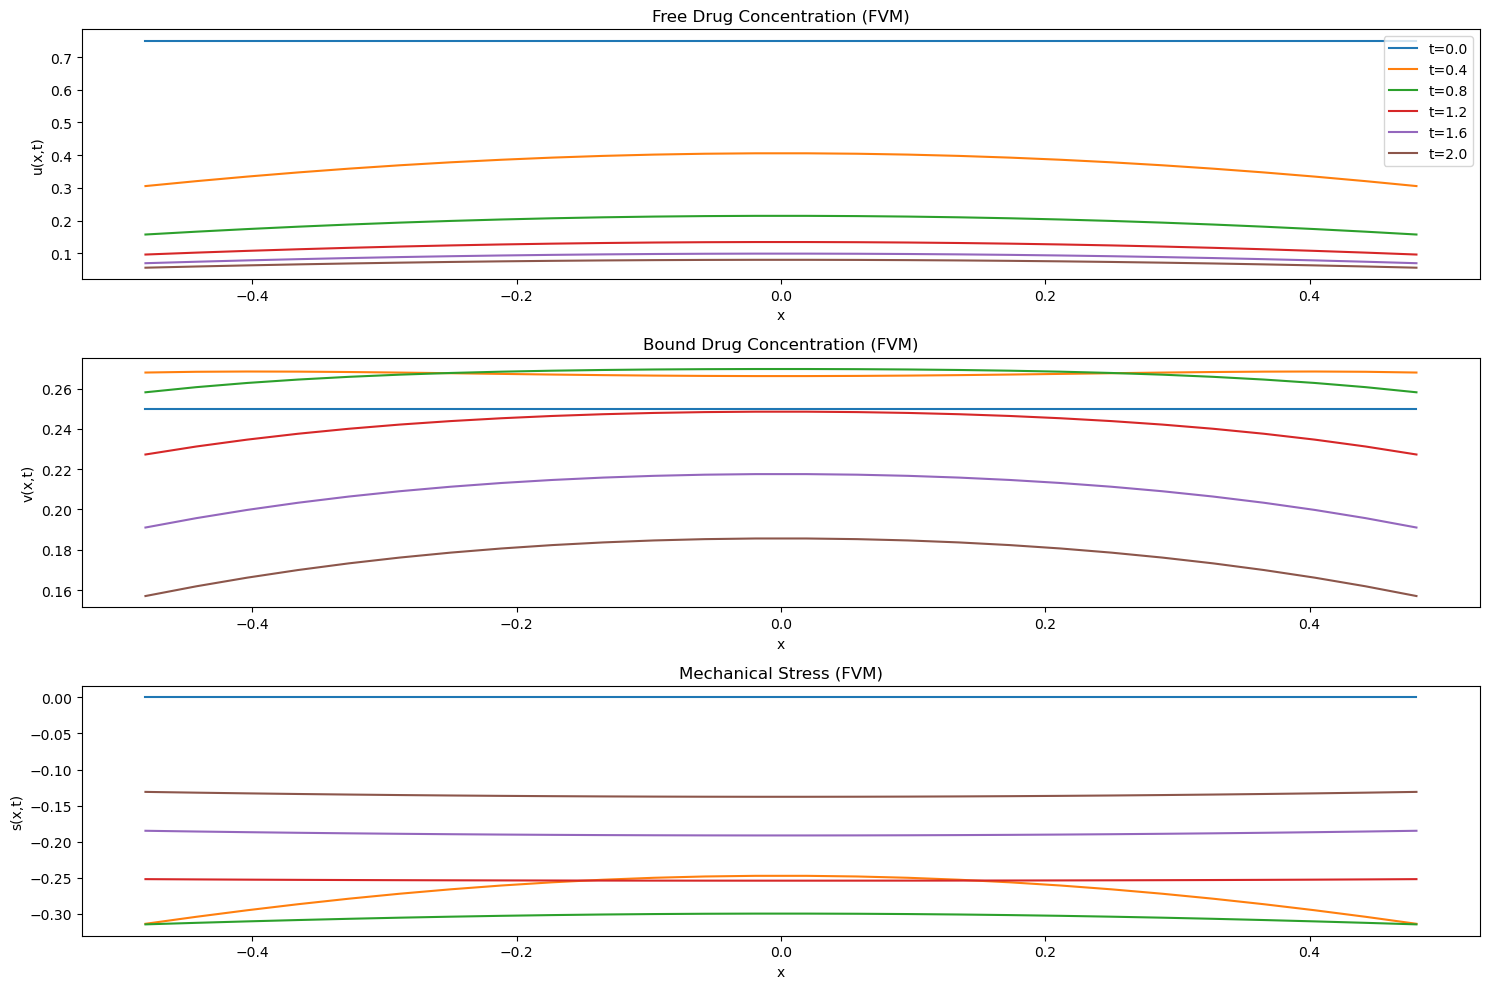

Generating comprehensive plots...


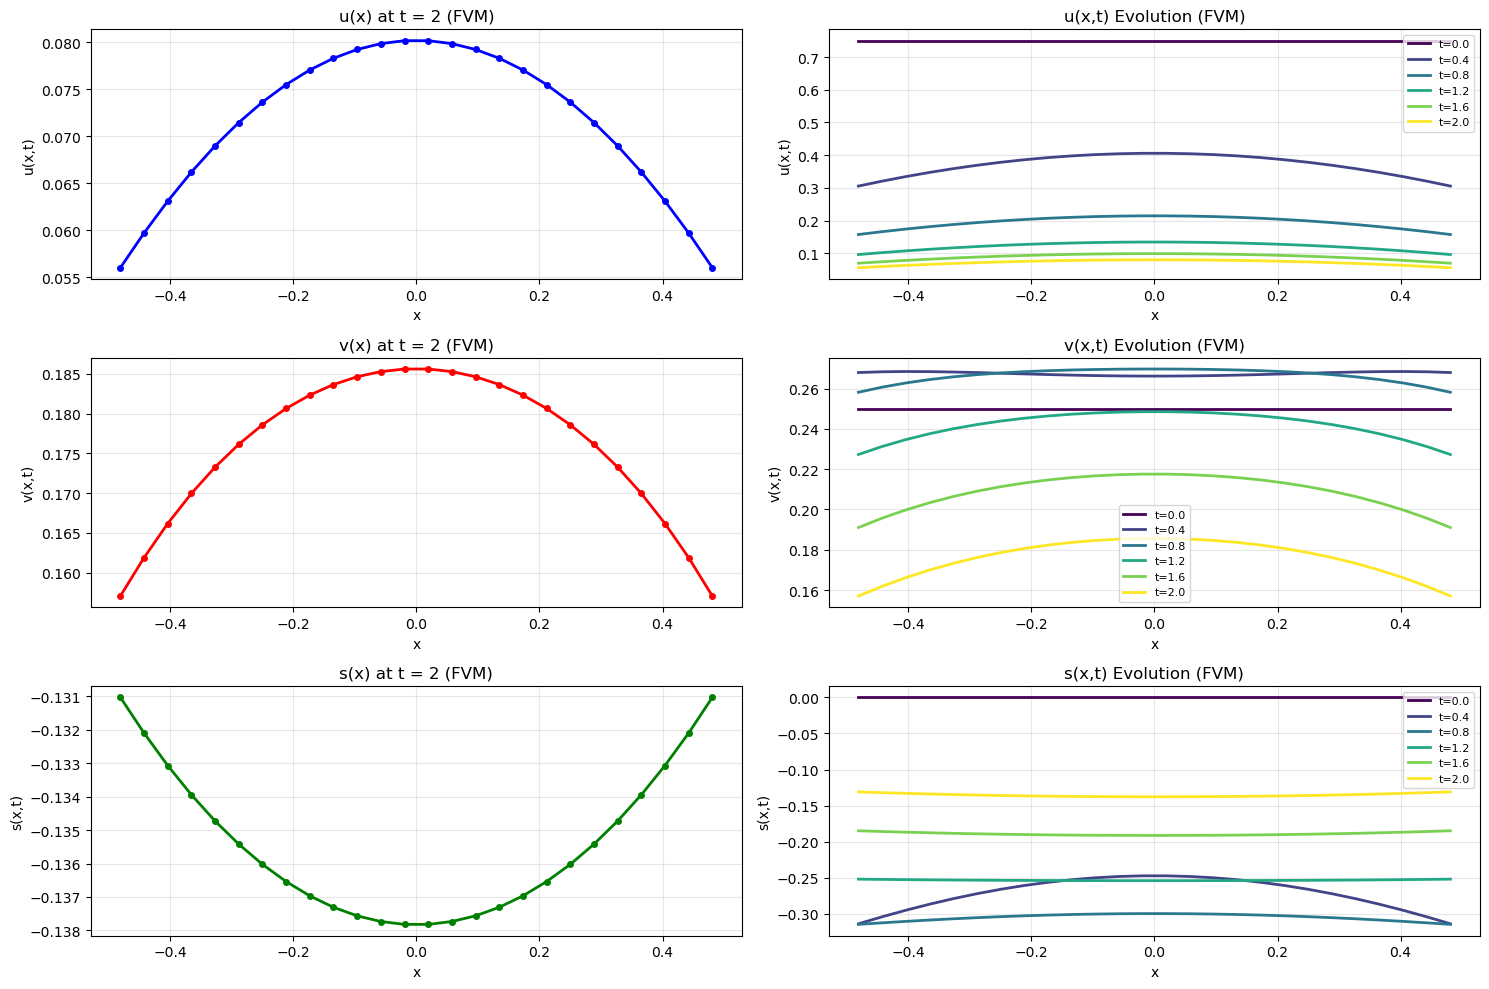

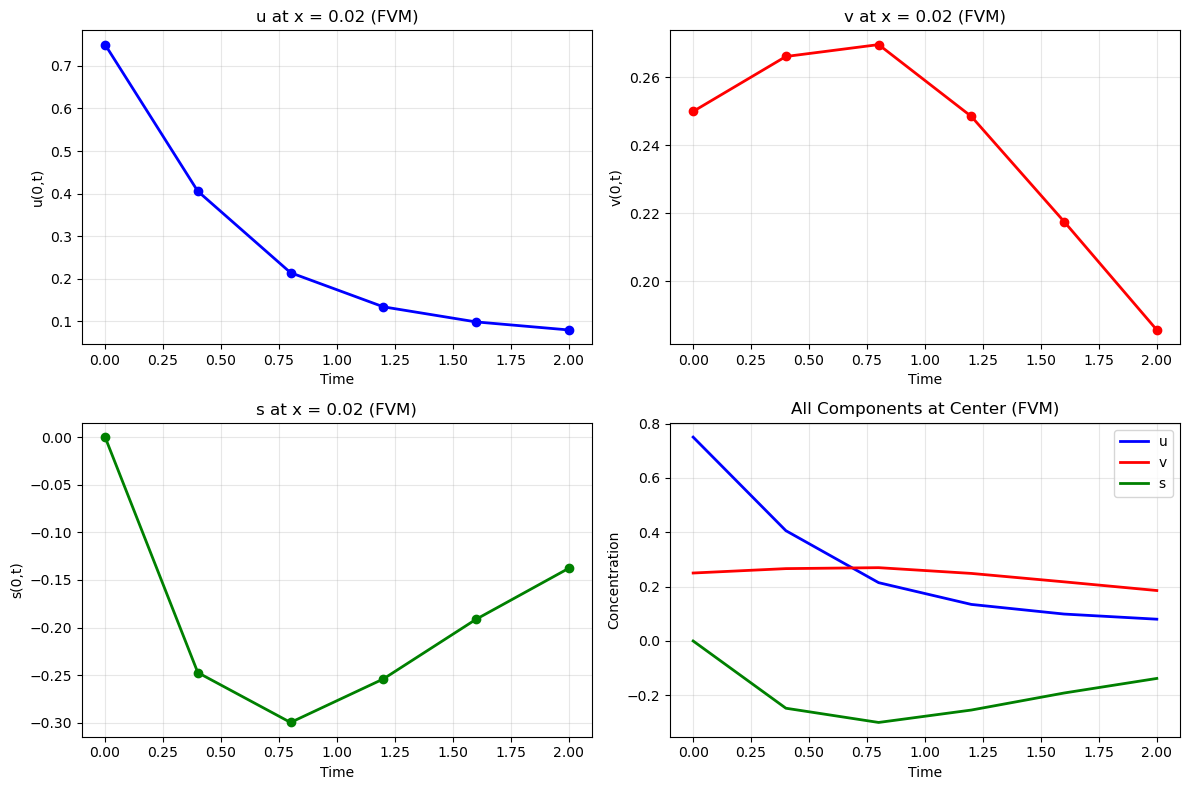


Model execution completed successfully!
Enhanced FVM features:
1. Original FVM spatial discretization maintained
2. Added comprehensive visualization from second code
3. Added tabular results display
4. Added temporal evolution plots at center point
5. Added final profile plots
6. Function call counter for performance monitoring
7. Both original and enhanced plotting options


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# GLOBAL VARIABLES AND PARAMETERS
# ==============================================================================

# Global counter for function calls
ncall = 0

# Parameters
alpha = 0.2
beta = 1.0
gamma = 1.0
D = 0.6
E = 0.2
kr = 1.0
ub = 1.0
vb = 1.0
ua = 0.0
xl = -0.5
xu = 0.5
nx = 26  # Number of control volumes
dx = (xu - xl) / nx  # Cell size
xg = np.linspace(xl + dx/2, xu - dx/2, nx)  # Cell centers

# Output configuration
ip = 1  # 1: spatial profiles, 2: temporal at x=0
if ip == 1:
    nout = 6
elif ip == 2:
    nout = 41
t0, tf = 0, 2
tout = np.linspace(t0, tf, nout)

print(f"\nModel Parameters:")
print(f"D = {D:6.3f}, E = {E:6.3f}")
print(f"Alpha = {alpha:6.3f}, Beta = {beta:6.3f}, Gamma = {gamma:6.3f}")
print(f"\nFVM Parameters:")
print(f"Cells = {nx}  dx = {dx:.4f}")

# ==============================================================================
# FINITE VOLUME METHOD FUNCTIONS
# ==============================================================================

def f_u(u, v):
    """Reaction function for u"""
    return -u * (ub - u) + v * (vb - v)

def g_v(u, v):
    """Reaction function for v"""
    return u * (ub - u) - v * (vb - v)

def calculate_fluxes(u, s):
    """Finite Volume Method (FVM) flux calculator"""
    # Initialize fluxes at faces (nx+1 faces)
    F_u = np.zeros(nx+1)  # Flux for u
    F_s = np.zeros(nx+1)  # Flux for s (contribution to u-equation)
    
    # Left boundary (face 0)
    F_u[0] = kr * (ua - u[0])  # Robin BC
    F_s[0] = 0.0  # Neumann BC (ds/dx=0)
    
    # Right boundary (face nx)
    F_u[nx] = -kr * (ua - u[-1])  # Robin BC
    F_s[nx] = 0.0  # Neumann BC (ds/dx=0)
    
    # Interior faces (central differences)
    for i in range(1, nx):
        F_u[i] = -D * (u[i] - u[i-1]) / dx  # -D*du/dx
        F_s[i] = -E * (s[i] - s[i-1]) / dx  # -E*ds/dx
    
    return F_u, F_s

def drug_fvm(t, U):
    """ODE system using FVM"""
    global ncall
    
    # Unpack state vector
    u = U[0:nx]
    v = U[nx:2*nx]
    s = U[2*nx:3*nx]
    
    # Calculate fluxes at faces
    F_u, F_s = calculate_fluxes(u, s)
    
    # Initialize time derivatives
    RHS_u = np.zeros(nx)
    RHS_v = np.zeros(nx)
    RHS_s = np.zeros(nx)
    
    # Compute du/dt for each control volume
    for i in range(nx):
        # Net flux = (Flux_in - Flux_out) / cell_size
        flux_u = (F_u[i] - F_u[i+1]) / dx
        flux_s = (F_s[i] - F_s[i+1]) / dx
        RHS_u[i] = flux_u + flux_s + f_u(u[i], v[i]) #  du/dt
    
    # Compute dv/dt and ds/dt
    for i in range(nx):
        RHS_v[i] = g_v(u[i], v[i])
        RHS_s[i] = alpha*u[i] - beta*s[i] + gamma*RHS_u[i]
    
    # Pack derivatives
    dUdt = np.concatenate([RHS_u, RHS_v, RHS_s])
    
    # Increment function call counter
    ncall += 1
    
    return dUdt

# ==============================================================================
# SOLUTION PROCESSING
# ==============================================================================

def extract_solutions(sol):
    """Extract u, v, s solutions from ODE output"""
    u_xplot = sol.y[0:nx, :].T
    v_xplot = sol.y[nx:2*nx, :].T
    s_xplot = sol.y[2*nx:3*nx, :].T
    
    return u_xplot, v_xplot, s_xplot

def display_results(u_xplot, v_xplot, s_xplot):
    """Display numerical results in tabular format"""
    print(f"\n{'='*70}")
    print(f"NUMERICAL RESULTS (FVM)")
    print(f"{'='*70}")
    
    # Display initial and final conditions
    for it in [0, nout-1]:
        print(f"\n\nTime t = {tout[it]:.1f}")
        print(f"{'x':>8} {'u(x,t)':>12} {'v(x,t)':>12} {'s(x,t)':>12}")
        print("-" * 50)
        for ix in range(0, nx, 5):  # Show every 5th point
            print(f"{xg[ix]:8.3f}{u_xplot[it, ix]:12.6f}"
                  f"{v_xplot[it, ix]:12.6f}{s_xplot[it, ix]:12.6f}")

# ==============================================================================
# COMPREHENSIVE VISUALIZATION
# ==============================================================================

def create_comprehensive_plots(u_xplot, v_xplot, s_xplot):
    """Create comprehensive plots like in the second code"""
    
    # Plot 1: Final profiles and evolution
    plt.figure(figsize=(15, 10))
    
    # u(x) at final time
    plt.subplot(3, 2, 1)
    plt.plot(xg, u_xplot[-1, :], 'bo-', linewidth=2, markersize=4)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'u(x) at t = {tf} (FVM)')
    plt.grid(True, alpha=0.3)
    
    # v(x) at final time
    plt.subplot(3, 2, 3)
    plt.plot(xg, v_xplot[-1, :], 'ro-', linewidth=2, markersize=4)
    plt.xlabel('x')
    plt.ylabel('v(x,t)')
    plt.title(f'v(x) at t = {tf} (FVM)')
    plt.grid(True, alpha=0.3)
    
    # s(x) at final time
    plt.subplot(3, 2, 5)
    plt.plot(xg, s_xplot[-1, :], 'go-', linewidth=2, markersize=4)
    plt.xlabel('x')
    plt.ylabel('s(x,t)')
    plt.title(f's(x) at t = {tf} (FVM)')
    plt.grid(True, alpha=0.3)
    
    # Evolution plots
    colors = plt.cm.viridis(np.linspace(0, 1, nout))
    
    # u evolution
    plt.subplot(3, 2, 2)
    for it in range(nout):
        plt.plot(xg, u_xplot[it, :], color=colors[it], linewidth=2, 
                label=f't={tout[it]:.1f}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('u(x,t) Evolution (FVM)')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    
    # v evolution
    plt.subplot(3, 2, 4)
    for it in range(nout):
        plt.plot(xg, v_xplot[it, :], color=colors[it], linewidth=2,
                label=f't={tout[it]:.1f}')
    plt.xlabel('x')
    plt.ylabel('v(x,t)')
    plt.title('v(x,t) Evolution (FVM)')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    
    # s evolution
    plt.subplot(3, 2, 6)
    for it in range(nout):
        plt.plot(xg, s_xplot[it, :], color=colors[it], linewidth=2,
                label=f't={tout[it]:.1f}')
    plt.xlabel('x')
    plt.ylabel('s(x,t)')
    plt.title('s(x,t) Evolution (FVM)')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('fvm_comprehensive_spatial.png')
    plt.show()
    
    # Plot 2: Time evolution at center point
    center_idx = nx // 2
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(tout, u_xplot[:, center_idx], 'b-o', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('u(0,t)')
    plt.title(f'u at x = {xg[center_idx]:.2f} (FVM)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(tout, v_xplot[:, center_idx], 'r-o', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('v(0,t)')
    plt.title(f'v at x = {xg[center_idx]:.2f} (FVM)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(tout, s_xplot[:, center_idx], 'g-o', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('s(0,t)')
    plt.title(f's at x = {xg[center_idx]:.2f} (FVM)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(tout, u_xplot[:, center_idx], 'b-', linewidth=2, label='u')
    plt.plot(tout, v_xplot[:, center_idx], 'r-', linewidth=2, label='v')
    plt.plot(tout, s_xplot[:, center_idx], 'g-', linewidth=2, label='s')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('All Components at Center (FVM)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fvm_comprehensive_temporal.png')
    plt.show()

def create_original_plots(u_sol, v_sol, s_sol):
    """Create the original plots from the first code"""
    if ip == 1:  # Spatial profiles
        plt.figure(figsize=(15, 10))
        
        plt.subplot(311)
        for i, t in enumerate(tout):
            plt.plot(xg, u_sol[:, i], label=f't={t:.1f}')
        plt.xlabel('x'); plt.ylabel('u(x,t)')
        plt.title('Free Drug Concentration (FVM)')
        plt.legend()
        
        plt.subplot(312)
        for i, t in enumerate(tout):
            plt.plot(xg, v_sol[:, i], label=f't={t:.1f}')
        plt.xlabel('x'); plt.ylabel('v(x,t)')
        plt.title('Bound Drug Concentration (FVM)')
        
        plt.subplot(313)
        for i, t in enumerate(tout):
            plt.plot(xg, s_sol[:, i], label=f't={t:.1f}')
        plt.xlabel('x'); plt.ylabel('s(x,t)')
        plt.title('Mechanical Stress (FVM)')
        
        plt.tight_layout()
        plt.savefig('fvm_original_spatial.png')
        plt.show()

    elif ip == 2:  # Temporal profile at x=0
        idx_center = np.argmin(np.abs(xg))
        u_center = u_sol[idx_center, :]
        v_center = v_sol[idx_center, :]
        s_center = s_sol[idx_center, :]
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(311)
        plt.plot(tout, u_center)
        plt.xlabel('Time'); plt.ylabel('u(0,t)')
        plt.title('Free Drug at Center (FVM)')
        
        plt.subplot(312)
        plt.plot(tout, v_center)
        plt.xlabel('Time'); plt.ylabel('v(0,t)')
        plt.title('Bound Drug at Center (FVM)')
        
        plt.subplot(313)
        plt.plot(tout, s_center)
        plt.xlabel('Time'); plt.ylabel('s(0,t)')
        plt.title('Stress at Center (FVM)')
        
        plt.tight_layout()
        plt.savefig('fvm_original_temporal.png')
        plt.show()

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main():
    """Main execution function"""
    global ncall
    
    print("="*70)
    print("DRUG RELEASE TRACKING MODEL - ENHANCED FVM VERSION")
    print("Three-PDE System with Finite Volume Method")
    print("="*70)
    
    # Initial conditions (cell-centered)
    u0_ic = 0.75 * np.ones(nx)
    v0_ic = 0.25 * np.ones(nx)
    s0_ic = np.zeros(nx)
    U0 = np.concatenate([u0_ic, v0_ic, s0_ic])
    
    # Reset function call counter
    ncall = 0
    
    # Solve ODE system
    print(f"\nSolving ODE system...")
    print(f"Spatial points: {nx}")
    print(f"Time points: {nout}")
    print(f"Total equations: {3*nx}")
    print(f"Integration from t = {t0} to t = {tf}")
    
    sol = solve_ivp(drug_fvm, [t0, tf], U0, t_eval=tout, method='LSODA')
    
    print(f"Solution completed.")
    print(f"Function calls: {ncall}")
    
    # Extract solutions
    u_sol = sol.y[0:nx, :]
    v_sol = sol.y[nx:2*nx, :]
    s_sol = sol.y[2*nx:3*nx, :]
    
    # Extract solutions in format compatible with second code plotting
    u_xplot, v_xplot, s_xplot = extract_solutions(sol)
    
    # Display results
    display_results(u_xplot, v_xplot, s_xplot)
    
    # Create original plots
    print(f"\nGenerating original plots...")
    create_original_plots(u_sol, v_sol, s_sol)
    
    # Create comprehensive plots (like second code)
    print(f"Generating comprehensive plots...")
    create_comprehensive_plots(u_xplot, v_xplot, s_xplot)
    
    return u_xplot, v_xplot, s_xplot, sol

# ==============================================================================
# RUN THE MODEL
# ==============================================================================

if __name__ == "__main__":
    # Execute main function
    u_xplot, v_xplot, s_xplot, sol = main()
    
    print(f"\nModel execution completed successfully!")
    print(f"Enhanced FVM features:")
    print(f"1. Original FVM spatial discretization maintained")
    print(f"2. Added comprehensive visualization from second code")
    print(f"3. Added tabular results display")
    print(f"4. Added temporal evolution plots at center point")
    print(f"5. Added final profile plots")
    print(f"6. Function call counter for performance monitoring")
    print(f"7. Both original and enhanced plotting options")